In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
import sys
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/scripts')

In [5]:
import myvariant
mv = myvariant.MyVariantInfo()

In [6]:
def process_data(file,analysis_type):
    if analysis_type=="linear":
        df=pd.read_csv(file,delimiter="\t",header=None)
        df.columns=["#CHROM","POS","ID","REF","ALT","A1","TEST","OBS_CT","BETA","SE","T_STAT","P","ERRCODE"]
        df["P"]=df["P"].astype(float)
        df['minuslog10pvalue'] = -np.log10(df["P"])
        df["#CHROM"]=df["#CHROM"].replace("X",23)
        df["#CHROM"]=pd.to_numeric(df["#CHROM"])
        df["#CHROM"] = df["#CHROM"].astype('category')
        df = df.sort_values('#CHROM')
        df['ind'] = range(len(df))
        return df
    if analysis_type=="logistic":
        df=pd.read_csv(file,delimiter="\t")
        df['minuslog10pvalue'] = -np.log10(df["P"])
        df["#CHROM"]=df["#CHROM"].replace("X",23)
        df["#CHROM"]=pd.to_numeric(df["#CHROM"])
        df["#CHROM"] = df["#CHROM"].astype('category')
        df = df.sort_values('#CHROM')
        df['ind'] = range(len(df))
        return df

In [7]:
def plot_manhattan_annotate(processed_data,title,color_list,files_known_snps,colors_known_snps):
    '''
    Input: dataframe with P values
    Output: Manhattan plot
    '''
    df=processed_data
    df_grouped = df.groupby(('#CHROM'))
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    colors = color_list
    x_labels = []
    x_labels_pos = []
    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='minuslog10pvalue',color=colors[num % len(colors)],ax=ax,rasterized=True)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))

    
    for num,file in enumerate(files_known_snps):
        snps=pd.read_csv(file,header=None)
        snps=snps[0].tolist()
        df_label=df[df["ID"].isin(snps)]
        print(df_label.shape)
        for i,row in df_label.iterrows():
            ax.scatter(row["ind"],row["minuslog10pvalue"],color=colors_known_snps[num],rasterized=True)
            
    ax.axhline(y=7.30, color='r', linestyle='-')
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    ax.set_xlim([0, len(df)])
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-log10 P value')
    ax.set_title(title+' GWAS Manhattan plot')
    fig.savefig(title+'.manhattan.labeled.pdf')
    #plt.close()

## Get conditional snps

In [8]:
def extract(directory):
    df_hla_cond=pd.DataFrame()
    files=[x for x in os.listdir(directory) if "assoc" in x]
    print(len(files))
    for x in files:
        df=pd.read_csv(directory+x,header=None,delimiter="\t")
        df["pheno"]=x.split(".assoc")[0]
        df["iteration"]=df.index
        df_hla_cond=df_hla_cond.append(df)
    df_hla_cond.columns=["snp","beta","p","file","iteration"]
    return(df_hla_cond)
    

In [9]:
def extract_beta(hla_df,betas):
    beta_values=[]
    p_values=[]

    for i,row in hla_df.iterrows():
        file=row["file"]+"."+str(row["iteration"])+".GWAS.ADD.filtered"
        try:
            df=pd.read_csv(betas+"/"+file,header=None,sep="\t")
            beta=df[(df[2]==row["snp"])&(df[6]=="ADD")][8].values[0]
            beta_values.append(beta)
            p=df[(df[2]==row["snp"])&(df[6]=="ADD")][11].values[0]
            p_values.append(p)
        except:
            beta=np.nan
            beta_values.append(beta)
            p=np.nan
            p_values.append(p)
            
    hla_df["beta"]=beta_values
    hla_df["p"]=p_values
    return(hla_df)
    

## Get HLA-conditional variants from all 3 pipelines

In [10]:
files=[x for x in os.listdir("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/raw/hla-conditional/firebrowse") if "assoc" in x]



In [11]:
compiled=pd.DataFrame()

for x in files:
    df=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/raw/hla-conditional/firebrowse/"+x,header=None,delimiter="\t")
    compiled=compiled.append(df)
    

In [12]:
compiled.head()

,0,1,2
0,6:29910371:C:T,-0.324122,4.131110e-33
1,6:29933439:T:C,0.113406,2.407130e-11
2,4:25466475:G:A,0.086680,2.539800e-07
3,X:25038156:C:T,0.095716,2.859360e-07
4,3:144824898:T:C,0.179215,9.158960e-07


In [13]:
tpm=extract("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/raw/hla-conditional/tpm/")
firebrowse=extract("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/raw/hla-conditional/firebrowse/")
pancan=extract("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/raw/hla-conditional/pancanatlas/")

14
17
17


# Get variants that are called by at least 2 RNA-sequencing pipelines

In [14]:
hla=tpm[["snp","file"]].append(firebrowse[["snp","file"]])
hla=hla.append(pancan[["snp","file"]])

In [15]:
#get conditional snps identified in at least 2 RNA pipelines
hla_counts=hla.groupby(["snp","file"]).size().reset_index()
hla_consensus=hla_counts[hla_counts[0]>1]["snp"].tolist()

In [16]:
hla_sig=hla[hla["snp"].isin(hla_consensus)]

In [17]:
hla_sig.head()

,snp,file
8,6:31364076:C:T,HLA.B
4,6:32789480:A:G,TAP2
5,6:32796793:G:A,TAP2
9,3:183987074:C:T,TAP2
9,6:31322980:C:T,HLA.C


## Get only chromosome 6

In [18]:
hla_sig["chr"]=hla_sig["snp"].str.split(":").str[0]
hla_sig6=hla_sig[hla_sig["chr"]=="6"]

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
print(hla_sig6.shape)
hla_sig6.head()

(82, 3)


,snp,file,chr
8,6:31364076:C:T,HLA.B,6
4,6:32789480:A:G,TAP2,6
5,6:32796793:G:A,TAP2,6
9,6:31322980:C:T,HLA.C,6
5,6:32403119:G:A,HLA.DRB5,6


## Get p and beta values of consensus variants

In [20]:
hla_merge=pd.merge(hla_sig6,tpm,on=["snp","file"],how="left",suffixes=('', '_tpm'))
hla_merge=pd.merge(hla_merge,firebrowse,on=["snp","file"],how="left",suffixes=('', '_firebrowse'))
hla_merge=pd.merge(hla_merge,pancan,on=["snp","file"],how="left",suffixes=('', '_pancan'))

In [21]:
hla_merge["beta mean"]=hla_merge[["beta", "beta_firebrowse","beta_pancan"]].mean(axis=1)

In [22]:
hla_merge["consensus p-value"]=hla_merge[["p", "p_firebrowse","p_pancan"]].min(axis=1)

In [23]:
hla_merge.head()

,snp,file,chr,beta,p,iteration,beta_firebrowse,p_firebrowse,iteration_firebrowse,beta_pancan,p_pancan,iteration_pancan,beta mean,consensus p-value
0,6:31364076:C:T,HLA.B,6,0.094710,4.980910e-18,8.0,NaN,NaN,NaN,NaN,NaN,NaN,0.094710,4.980910e-18
1,6:32789480:A:G,TAP2,6,0.597560,5.918920e-21,4.0,0.132922,7.146760e-12,1.0,0.132970,2.695510e-12,1.0,0.287817,5.918920e-21
2,6:32796793:G:A,TAP2,6,-0.147194,4.220380e-11,5.0,-0.379908,7.175220e-32,0.0,-0.382238,2.281790e-33,0.0,-0.303113,2.281790e-33
3,6:31322980:C:T,HLA.C,6,0.057450,8.952920e-08,9.0,NaN,NaN,NaN,NaN,NaN,NaN,0.057450,8.952920e-08
4,6:32403119:G:A,HLA.DRB5,6,-0.385607,1.408260e-46,5.0,NaN,NaN,NaN,-0.254001,3.540090e-11,4.0,-0.319804,1.408260e-46


## Plot manhattan

In [24]:
df=process_data("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/raw/hla-conditional/tpm/TAP2.4.GWAS.ADD","linear")

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [25]:
df=df[df["#CHROM"]==6]
df=df[df["POS"]>32700000]
df=df[df["POS"]<32800000]

In [26]:
snps=["6:32789480:A:G","6:32796793:G:A"]

In [27]:
df[df["ID"].isin(snps)]

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,minuslog10pvalue,ind
2949444,6,32789480,6:32789480:A:G,A,G,G,ADD,7113,0.597560,0.063428,9.42103,5.918920e-21,.,20.227758,3127959
2949522,6,32796793,6:32796793:G:A,G,A,A,ADD,7113,-0.142052,0.022416,-6.33691,2.487700e-10,.,9.604202,3128129


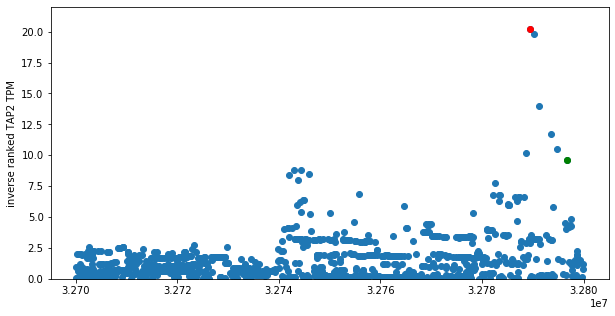

In [28]:
f=plt.figure(figsize=(10,5))
plt.scatter(df["POS"],df["minuslog10pvalue"])
plt.scatter(32789480,20.227758,color="red",rasterized=True)
plt.scatter(32796793,9.604202,color="green",rasterized=True)
plt.ylabel("inverse ranked TAP2 TPM")
plt.ylim([0, 22])
plt.savefig("../plots/tap2.iteration4.pdf")

In [29]:
df=process_data("/cellar/users/mpagadal/Data2/projects/germline-immune/hla-deep-dive/associations/raw/hla-conditional/tpm/TAP2.5.GWAS.ADD","linear")

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [30]:
df=df[df["#CHROM"]==6]
df=df[df["POS"]>32700000]
df=df[df["POS"]<32800000]

In [31]:
df[df["ID"].isin(snps)]

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,minuslog10pvalue,ind
2949444,6,32789480,6:32789480:A:G,A,G,G,ADD,7113,NaN,NaN,NaN,NaN,CORR_TOO_HIGH,NaN,3127959
2949522,6,32796793,6:32796793:G:A,G,A,A,ADD,7113,-0.147194,0.02228,-6.60649,4.220380e-11,.,10.374648,3128129


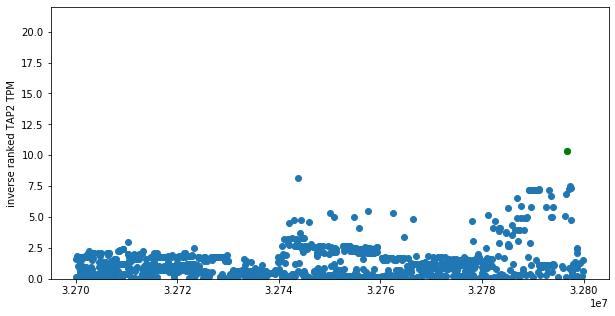

In [32]:
f=plt.figure(figsize=(10,5))
plt.scatter(df["POS"],df["minuslog10pvalue"])
plt.scatter(32796793,10.374648,color="green",rasterized=True)
plt.ylabel("inverse ranked TAP2 TPM")
plt.ylim([0, 22])
plt.savefig("../plots/tap2.iteration5.pdf")

## make conditional plot

In [33]:
hla_merge["bp1"]=hla_merge["snp"].str.split(":").str[1]
hla_merge["bp1"]=pd.to_numeric(hla_merge["bp1"])

In [34]:
hla_merge["-log10p"]=-np.log10(hla_merge["consensus p-value"])

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [35]:
hla_merge["-log10p"]=hla_merge["-log10p"].replace(np.inf, np.nan)
hla_merge["-log10p"]=hla_merge["-log10p"].fillna(hla_merge["-log10p"].max())

## Get allele-specific HLA snps

In [36]:
ase=extract("/cellar/users/mpagadal/Data2/projects/germline-immune/hla-deep-dive/associations/raw/hla-conditional/ase/")

8


In [37]:
ase.head()

,snp,beta,p,file,iteration
0,5:148346443:G:A,0.117256,1.057200e-07,HLA.DRB1,0
1,X:153709976:C:T,-0.108363,2.895240e-07,HLA.DRB1,1
2,16:14909621:C:T,0.293905,4.478530e-07,HLA.DRB1,2
3,2:169198105:T:C,0.090081,7.703280e-07,HLA.DRB1,3
4,12:48302860:T:C,-0.184518,1.257360e-06,HLA.DRB1,4


In [38]:
# def get_clumps(directory,snp_type):
#     '''
#     Input: directory with all plink .clumped files to be aggregated
#     Output: dataframe with INDEX SNP, p-value, association paramter
#     '''
#     #get clumped files
#     files=os.listdir(directory)
#     file_lst=[x for x in files if ".clumped" in x]
    
#     if snp_type == "index":
    
#         #iterate through all clumped files and extract index snps
#         snps=[]
#         assoc=[]
#         p=[]

#         for x in file_lst:
#             file=pd.read_csv(directory+"/"+x, delim_whitespace=True)
#             for i,row in file.iterrows():
#                 snps.append(row["SNP"])
#                 p.append(row["P"])
#                 assoc.append(x.split(".clump.clumped")[0])
    
#         df=pd.DataFrame({"snps":snps,"file":assoc,"p-value":p})
#         return(df)
    
#     if snp_type == "all":
#         snps=[]
#         indexsnp=[]
#         assoc=[]
#         p=[]

#         for x in file_lst:
#             file=pd.read_csv(directory+"/"+x, delim_whitespace=True)
#             for i,row in file.iterrows():
#                 for y in row["SP2"].split("(1),"):
#                     snps.append(y)
#                     indexsnp.append(row["SNP"])
#                     p.append(row["P"])
#                     assoc.append(x.split(".clump.clumped")[0])
                
#         df=pd.DataFrame({"indexsnps":indexsnp,"snps":snps,"file":assoc,"p-value":p})
#         df=df[~(df["snps"]=="")]
#         df=df[~(df["snps"]=="NONE")]
#         df["snps"]=df["snps"].str.split("(").str[0]
#         return(df)

In [39]:
# def compiled(directory):
#     files=os.listdir(directory)
    
#     compiled=pd.DataFrame()
    
#     for x in files:
#         try:
#             df=pd.read_csv(directory+"/"+x,delimiter="\t",header=None)
#             df_filt=df[df[6]=="ADD"]
#             df_filt["file"]=x.split(".sig.snps")[0]
#             compiled=compiled.append(df_filt)
#         except:
#             print(x)
    
#     return(compiled)

In [40]:
def map_rsid(x):
    '''
    Input: SNP format (chr:bp:minor:major)
    Output: tuple (variant,rsid)
    '''
    try:
        var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[2]+">"+x.split(":")[3]
        rs=mv.getvariants(var,fields='dbsnp.rsid')[0]["dbsnp"]["rsid"]
    except:
        try:
            var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[3]+">"+x.split(":")[2]
            rs=mv.getvariants(var,fields='dbsnp.rsid')[0]["dbsnp"]["rsid"]
        except:
            var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[3]+">"+x.split(":")[2]
            rs=""
    
    return (var,rs)

In [41]:
# ase=get_clumps("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/clump/hla-ase","index")

In [42]:
ase["chr"]=ase["snp"].str.split(":").str[0]
ase["bp1"]=ase["snp"].str.split(":").str[1]
ase["bp1"]=pd.to_numeric(ase["bp1"])
ase["-log10"]=-np.log10(ase["p"])
ase["-log10"]=pd.to_numeric(ase["-log10"])

In [43]:
#get chromosome 6 variants
ase6=ase[ase["chr"]=="6"]

In [44]:
ase6

,snp,beta,p,file,iteration,chr,bp1,-log10
0,6:32580657:T:C,0.261701,2.299240e-36,HLA.DQA1,0,6,32580657,35.638416
0,6:31239896:T:C,-0.281165,6.027040e-24,HLA.C,0,6,31239896,23.219896
1,6:31243767:G:C,0.146062,5.002100e-11,HLA.C,1,6,31243767,10.300848
5,6:7933211:G:A,0.375120,7.672040e-07,HLA.C,5,6,7933211,6.115089
0,6:32620572:A:G,0.488599,2.578730e-111,HLA.DQB1,0,6,32620572,110.588594
1,6:32651641:G:T,-0.274820,9.728810e-20,HLA.DQB1,1,6,32651641,19.011940
2,6:32681161:T:G,0.166554,4.317680e-12,HLA.DQB1,2,6,32681161,11.364750
0,6:31931137:T:C,0.126899,2.565020e-07,HLA.B,0,6,31931137,6.590909
0,6:33077271:A:G,-0.183482,4.143040e-12,HLA.DPB1,0,6,33077271,11.382681
0,6:29910358:G:C,-0.235401,1.523340e-31,HLA.A,0,6,29910358,30.817203


In [45]:
# ase_compiled=compiled("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/associations/filtered/hla-ase")

In [46]:
# ase_compiled=ase_compiled.rename(columns={2:"snps",8:"beta",9:"SE",11:"P",3:"REF",4:"ALT"})

In [47]:
# ase6=pd.merge(ase6,ase_compiled[["snps","beta","SE","P","file","REF","ALT"]],on=["snps","file"],how="left")

In [48]:
# ase6.head()

In [49]:
n=ase6.file.unique().tolist()+hla_merge.file.unique().tolist()
color=iter(cm.rainbow(np.linspace(0,1,len(n))))

color_dict={}
for t, c in zip(n, color):
    color_dict[t]=c

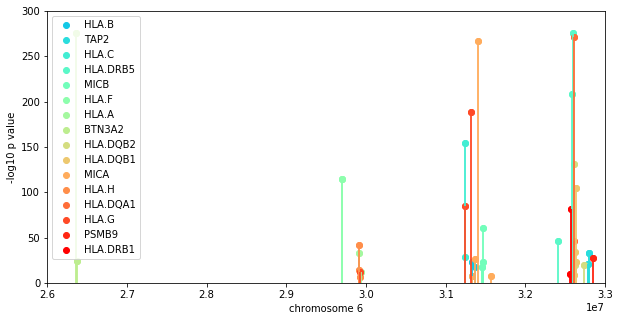

In [50]:
f=plt.figure(figsize=(10,5))
for t in hla_merge.file.unique():
    plt.scatter(hla_merge[hla_merge.file==t]["bp1"], hla_merge[hla_merge.file==t]["-log10p"],label=t,color=color_dict[t])
    plt.vlines(x=hla_merge[hla_merge.file==t]["bp1"], ymin=0,ymax=hla_merge[hla_merge.file==t]["-log10p"], color=color_dict[t], alpha=0.7, linewidth=2)
plt.legend()
plt.ylim([0, 300])
plt.xlim([26000000, 33000000])
plt.ylabel("-log10 p value")
plt.xlabel("chromosome 6")
plt.savefig("../plots/hla.cond.pdf")

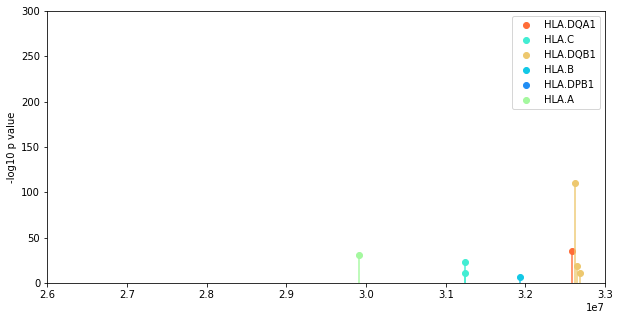

In [51]:
f=plt.figure(figsize=(10,5))
for t in ase6.file.unique():
    plt.scatter(ase6[ase6.file==t]["bp1"], ase6[ase6.file==t]["-log10"],label=t,color=color_dict[t])
    plt.vlines(x=ase6[ase6.file==t]["bp1"], ymin=0,ymax=ase6[ase6.file==t]["-log10"], color=color_dict[t], alpha=0.7, linewidth=2)
plt.legend()
plt.ylim([0, 300])
plt.xlim([26000000, 33000000])
plt.ylabel("-log10 p value")
plt.savefig("../plots/hla.ase.pdf")

## Make dataframes

In [52]:
ase6_filt=ase6[["snp","file","beta","p"]]
ase6_filt.columns=["snps","file","beta","p-value"]
ase6_filt["method"]="ase"

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
cond_filt=hla_merge[["snp","file","beta mean","consensus p-value"]]
cond_filt.columns=["snps","file","beta","p-value"]
cond_filt["method"]="conditional"

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
total_hla=ase6_filt.append(cond_filt)

In [55]:
total_hla=total_hla.drop_duplicates()

In [56]:
#map to rsid
total_hla['variant'] = total_hla['snps'].apply(lambda x: map_rsid(x)[0])
total_hla['rsid'] = total_hla['snps'].apply(lambda x: map_rsid(x)[1])

querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1...done.
querying 1-1.

In [57]:
len(cond_filt.drop_duplicates())

40

In [58]:
len(ase6_filt.drop_duplicates())

10

In [59]:
total_hla.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-hla.tsv",index=None,sep="\t")

## Extract file

In [60]:
snps=total_hla["snps"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in total_hla["snps"].tolist()]

In [61]:
extract=pd.DataFrame({"snps":snps})

In [62]:
extract.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/extract-hla-variants.txt",header=None,sep="\t",index=None)

## Export for LDtrait

In [63]:
for num,data in enumerate(np.array_split(total_hla["rsid"], 5)):
    print(len(data))
    data.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/LDtrait/hla.LDlink_input_"+str(num)+".tsv",header=None,index=None,sep="\t")

10
10
10
10
10


## Get LDtrait output

In [64]:
directory="/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/LDtrait/"

In [65]:
files=[x for x in os.listdir(directory) if "hla_LDlink_output_" in x]

In [66]:
total_gwas=pd.DataFrame()

for x in files:
    gwas=pd.read_csv(directory+x,delimiter="\t")
    total_gwas=total_gwas.append(gwas)

In [67]:
mp_trait={}

for x in total_gwas["Query"].unique():
    mp_trait[x]=total_gwas[total_gwas["Query"]==x]["GWAS Trait"].unique().tolist()
    
    

In [79]:
total_gwas

,Query,GWAS Trait,RS Number,Position (GRCh37),Alleles,R2,D',Risk Allele,Effect Size (95% CI),Beta or OR,P-value
0,rs3130510,Idiopathic membranous nephropathy,rs2233956,chr6:31081205,"C=0.152, T=0.848",0.575574,0.878388,0.1813,2.770000,NaN,6.000000e-48
1,rs3130510,Lung cancer in ever smokers,rs2233956,chr6:31081205,"C=0.152, T=0.848",0.575574,0.878388,0.167124691,1.173029,1.128692308-1.219106364,5.000000e-16
2,rs3130510,Psoriasis,rs1576,chr6:31110391,"C=0.314, G=0.686",0.501731,0.977570,NR,1.670000,1.41‐1.99,2.000000e-07
3,rs3130510,Nevirapine-induced rash,rs1265112,chr6:31118019,"C=0.314, T=0.686",0.501731,0.977570,0.06,4.360000,2.58-7.36,1.000000e-08
4,rs3130510,Epstein-Barr virus copy number in lymphoblasto...,rs1062630,chr6:31138107,"A=0.201, G=0.799",0.957014,1.000000,NR,NaN,NaN,1.000000e-06
...,...,...,...,...,...,...,...,...,...,...,...
161,rs9260555,Heel bone mineral density,rs9260426,chr6:29919109,"A=0.448, G=0.552",0.668722,0.934258,NR,0.022923,0.019-0.027,6.000000e-27
162,rs9260555,Heel bone mineral density,rs7747253,chr6:29919779,"A=0.557, C=0.443",0.676383,0.930191,0.499099,0.022146,0.019-0.026,1.000000e-33
163,rs9260555,Multiple sclerosis,rs9260489,chr6:29920332,"G=0.626, T=0.374",0.917709,0.978423,0.45,1.210000,NaN,1.000000e-11
164,rs9260555,Beta-2 microglubulin plasma levels,rs9260489,chr6:29920332,"G=0.626, T=0.374",0.917709,0.978423,0.58,0.040000,0.032-0.048,2.000000e-22


## Plot GWAS traits

In [69]:
g=[]
c=[]

for x in total_gwas["GWAS Trait"].unique():
    g.append(x)
    c.append(len(total_gwas[total_gwas["GWAS Trait"]==x]["Query"].unique()))

In [70]:
gwas_counts=pd.DataFrame({"gwas":g,"counts":c})
gwas_counts=gwas_counts.sort_values(by="counts",ascending=False)

In [71]:
gwas_counts["counts"]=gwas_counts["counts"]

In [72]:
gwas_counts_filt=gwas_counts[gwas_counts["counts"]>5]

In [73]:
gwas_counts_filt["gwas"]=gwas_counts_filt["gwas"].str.split("(").str[0]
mp={"Asthma ":"Asthma"}

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [74]:
gwas_counts_filt["gwas"]=gwas_counts_filt["gwas"].map(mp).fillna(gwas_counts_filt["gwas"])

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


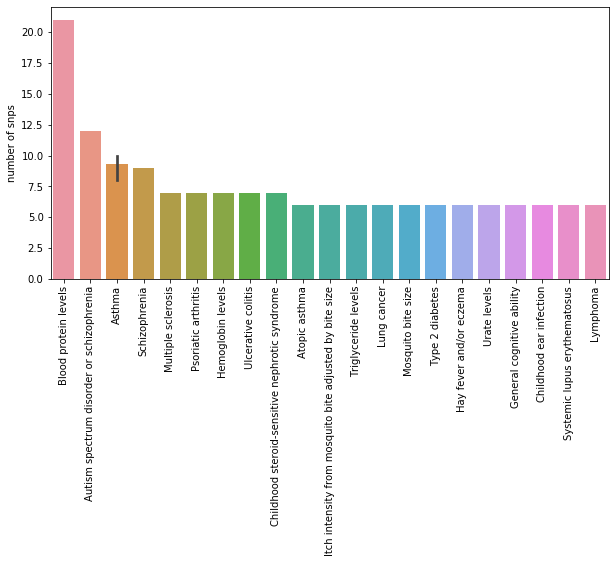

In [75]:
f=plt.figure(figsize=(10,5))
ax = sns.barplot(x="gwas", y="counts", data=gwas_counts_filt)
plt.xlabel("")
plt.ylabel("number of snps")
plt.xticks(rotation=90)
f.savefig("../plots/gwas.pdf")

In [76]:
df=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-hla.tsv",delimiter="\t")

In [77]:
df[df["rsid"]=="rs2844806"]

,snps,file,beta,p-value,method,variant,rsid
19,6:29933439:T:C,HLA.A,0.116323,9.748700e-13,conditional,chr6:g.29933439C>T,rs2844806


In [78]:
df[df["rsid"]=="rs1143146"]

,snps,file,beta,p-value,method,variant,rsid
9,6:29910358:G:C,HLA.A,-0.235401,1.523340e-31,ase,chr6:g.29910358C>G,rs1143146
